# Modeling

In this notebook I will build **models to predict the student course outcome.** In previous notebook **EDA** I've performed the **exploratory analysis and built some visualizations**. At the end the new dataset was stored as "final_data.csv" file in data folder.

## Goal of the Modeling
The main goal of the project is to be able to predict the outcome of the students in the course. I will build different algorithms of **multiclass classification models and evaluate their performance**. At the end of the notebook I will choose a model that has the **most appropriate parameters and performed the best.**

## Import Packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.cluster import KMeans
from xgboost import XGBClassifier as XGB


from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc


# Import additional files with statistical functions
import sys
import os

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import explore_data as ed 
import model_functions as mf
import model_history as mh

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

plt.style.use('seaborn-dark')
sns.set_theme('talk')

## Upload Dataset

In [3]:
df = pd.read_csv('../data/final_data.csv', dtype={"id_student": str})

In [4]:
df.columns

Index(['module_presentation_length', 'code_module', 'code_presentation',
       'id_student', 'date_registration', 'sum_click', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'mean_score'],
      dtype='object')

In [5]:
ed.show_info(df)

Lenght of Dataset: 20224
                            missing_values_% Data_type
module_presentation_length               0.0     int64
code_module                              0.0    object
code_presentation                        0.0    object
id_student                               0.0    object
date_registration                        0.0     int64
sum_click                                0.0     int64
gender                                   0.0    object
region                                   0.0    object
highest_education                        0.0    object
imd_band                                 0.0    object
age_band                                 0.0    object
num_of_prev_attempts                     0.0     int64
studied_credits                          0.0     int64
disability                               0.0    object
final_result                             0.0    object
mean_score                               0.0   float64


* I will drop columns that are not relevant to modeling, such that id_student and code_presentation

In [6]:
df.drop(columns = ['id_student', 'code_presentation'], inplace = True)

In [7]:
df.rename(columns = {'module_presentation_length': 'course_length', 
                     'num_of_prev_attempts': 'attempts'}, inplace = True)
df.head()

,course_length,code_module,date_registration,sum_click,gender,region,highest_education,imd_band,age_band,attempts,studied_credits,disability,final_result,mean_score
0,262,DDD,88,458,M,North Western Region,Lower Than A Level,0-10%,0-35,0,60,N,Pass,86.50
1,262,DDD,136,1107,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,80.00
2,262,DDD,107,663,M,West Midlands Region,A Level or Equivalent,90-100%,0-35,0,60,N,Pass,86.00
3,262,DDD,99,729,M,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,90,N,Fail,65.25
4,262,DDD,143,453,F,South Region,A Level or Equivalent,40-50%,0-35,0,60,Y,Pass,87.50


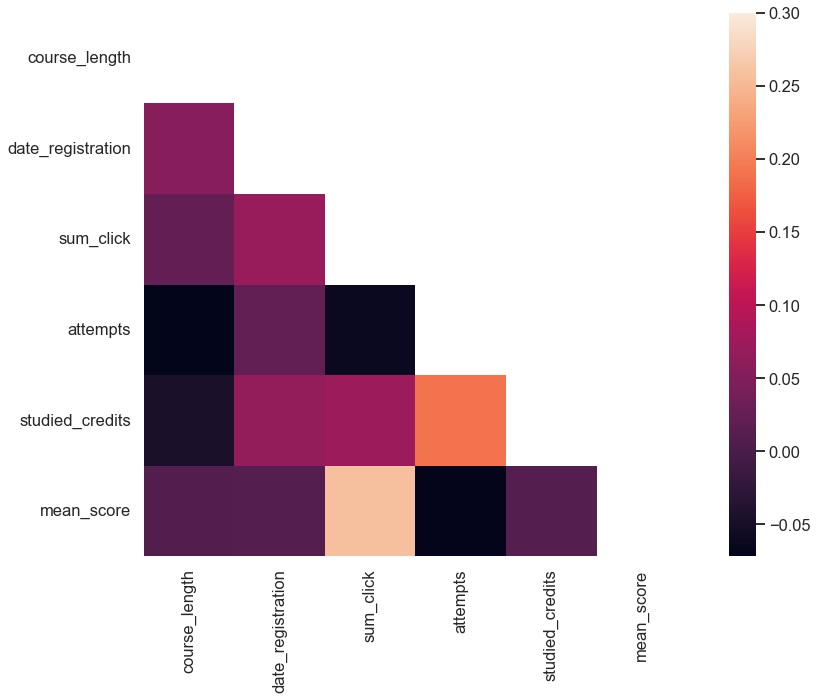

In [8]:
corr = df.corr(method = 'pearson')

mask = np.triu(np.ones_like(corr, dtype='bool'))

with sns.axes_style("white"):
    f,ax = plt.subplots(figsize = (15,10))
    ax = sns.heatmap(corr, mask = mask, vmax = 0.3, square = True)

In [9]:
#df['final_result'] = df['final_result'].map({'Pass': 1, 'Fail': 0}).astype(int)

## Features

* **course_length:** length of the code_module in days.
* **code_module:** three letter id of the course.
* **date_registration:** number of days student registered before the course beginning.
* **sum_click:** sum of click student made on Vle for given course.
* **gender:** gender of the student.
* **region:** region of student location in UK.
* **highest_education:** education level of the student.
* **imd_band:** indices of multiple deprivation - a measure of economic status.
* **age_band:** age category of the student.
* **attempts:** number of times the student has attempted the class.
* **disability:** disability status of the student.
* **studied credits:** number of credits student acquired by the begginning of the course.
* **mean_score:** The student's mean assessment score.


### Binarize Classes

In [10]:
df['final_result'] = df['final_result'].apply(lambda x: 0 if ('Pass' in x or 'Distinct' in x ) else 1)
df['final_result'].value_counts()

0    14628
1     5596
Name: final_result, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20224 entries, 0 to 20223
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      20224 non-null  int64  
 1   code_module        20224 non-null  object 
 2   date_registration  20224 non-null  int64  
 3   sum_click          20224 non-null  int64  
 4   gender             20224 non-null  object 
 5   region             20224 non-null  object 
 6   highest_education  20224 non-null  object 
 7   imd_band           20224 non-null  object 
 8   age_band           20224 non-null  object 
 9   attempts           20224 non-null  int64  
 10  studied_credits    20224 non-null  int64  
 11  disability         20224 non-null  object 
 12  final_result       20224 non-null  int64  
 13  mean_score         20224 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 2.2+ MB


### Train-Test Split

To prevent models from **overfitting** and to be able to **accurately evaluate model** I will split the data to **X as a features and y as a target variable, and split data into three sets: train, test and holdout.**

In [12]:
X = df.drop("final_result", axis=1)
y = df['final_result']

Now, split the data to **train and holdout sets** and then **split the train set into test and train sets too.**

In [13]:
x_all, x_hold, y_all, y_hold = train_test_split(X, y, train_size = 0.80, random_state=2021)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size = 0.75,random_state=2021)

### Data Imbalance

I will check how balanced my train data is based on target feature

In [14]:
pd.Series(y_train).value_counts(normalize=True)

0    0.720949
1    0.279051
Name: final_result, dtype: float64

* It is clear that train set is imbalanced. I will build first model with this data and later on try to balance it using SMOTE.

## Baseline Model - Logistic Regression

### ColumnTransformer for Categorical Features

Before I start any modeling, I will use **ColumnTransformer and OneHotEncode** all categorical features of the dataframe:

In [15]:
cat_cols = x_train.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train.columns.get_loc(col))
indices

[1, 4, 5, 6, 7, 8, 11]

In [16]:
transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)])

### Build a Pipeline

In [17]:
categ_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                               LR(C=0.01, random_state=2021, max_iter = 5000))

categ_pipeline.fit(x_train, y_train)
categ_pipeline.score(x_test, y_test)

history = mh.ModelHistory()

In [18]:
history.report(categ_pipeline,x_train, y_train, 'Logistic Regression - multinomial', 
               'Regression with Numeric and Categorical Features')

Average Accuracy Score: 0.7221873552712175
Average Recall Score: 0.03546788741689424
Average Precision Score: 0.5314309859561576
Average F1 Score: 0.06639200073797755


In [19]:
train_preds = categ_pipeline.predict(x_train)
test_preds = categ_pipeline.predict(x_test)

In [20]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.682895158147608
Recall Score: 0.7235866161199934
Accuracy Score: 0.7235866161199934
F1 Score: 0.6239501152435228


Precision Score: 0.6511154625513287
Recall Score: 0.7184177997527812
Accuracy Score: 0.7184177997527812
F1 Score: 0.6185505317605995




<Figure size 720x720 with 0 Axes>

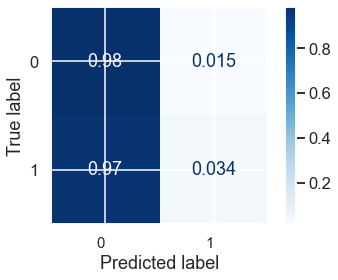

In [21]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(categ_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [22]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8780
False    3354
Name: final_result, dtype: int64


In [23]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2906
False    1139
Name: final_result, dtype: int64


**Model Results:**
* There is no overfitting since model evaluation scores for train and test splits are close enough to each other.
* From confusion matrix it is clear that model predicting most of the outcomes as "Pass".
* About 1/3 of outcomes were predicted falsely based on residuals

## Logistic Regression with Upsampled Data

Since the classes of the target are imbalanced,  will use SMOTE() to upsample data.

In [24]:
upsample_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                              SMOTE(random_state = 2021), 
                              LR(C=0.01, random_state=2021))

upsample_pipe.fit(x_train, y_train)
upsample_pipe.score(x_test, y_test)

history.report(upsample_pipe,x_train, y_train, 'Logistic Regression', 
               'Regression with Upsampled Data')

Average Accuracy Score: 0.5943641169048651
Average Recall Score: 0.5881920480181895
Average Precision Score: 0.3606393267528933
Average F1 Score: 0.44694544710481693


In [25]:
train_preds = upsample_pipe.predict(x_train)
test_preds = upsample_pipe.predict(x_test)

In [26]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6746453195626928
Recall Score: 0.5979067084226142
Accuracy Score: 0.5979067084226142
F1 Score: 0.6182357510526185


Precision Score: 0.677889805650391
Recall Score: 0.596044499381953
Accuracy Score: 0.596044499381953
F1 Score: 0.616498506975775




<Figure size 720x720 with 0 Axes>

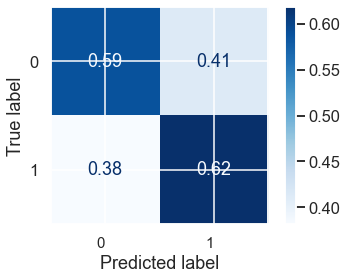

In [27]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(upsample_pipe, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [28]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     7255
False    4879
Name: final_result, dtype: int64


In [29]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2411
False    1634
Name: final_result, dtype: int64


**Model Results:**

* Upsampled model performed worse than imbalanced data in terms of evaluation metrics
* The confusion matrix shows better performance in term of high diagonal values.

## Grid Search for C Value

In [30]:
C = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

parameters = dict(logisticregression__C=C)

clf_GS = GridSearchCV(upsample_pipe, parameters)

clf_GS.fit(x_train, y_train)


print('Best C:', clf_GS.best_estimator_.get_params()['logisticregression__C'])

Best C: 0.05


In [31]:
lr_pipeline_2 = make_pipeline(transformer, StandardScaler(with_mean = False), SMOTE(),
                              LR(C=clf_GS.best_estimator_.get_params()['logisticregression__C'],
                                                 random_state=2021, max_iter = 5000))
lr_pipeline_2.fit(x_train, y_train)
lr_pipeline_2.score(x_test, y_test)

0.5953028430160692

In [32]:
history.report(lr_pipeline_2,x_train, y_train, 'Logistic Regression', 
               'Regression with All Features and Best C - Value')

Average Accuracy Score: 0.5921388418437818
Average Recall Score: 0.5881999685966902
Average Precision Score: 0.3589263609173624
Average F1 Score: 0.4456684337571981


In [33]:
train_preds = lr_pipeline_2.predict(x_train)
test_preds = lr_pipeline_2.predict(x_test)

In [34]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6751920775259833
Recall Score: 0.5979067084226142
Accuracy Score: 0.5979067084226142
F1 Score: 0.6182636711059206


Precision Score: 0.6746708545811225
Recall Score: 0.5953028430160692
Accuracy Score: 0.5953028430160692
F1 Score: 0.6157073371757074




<Figure size 720x720 with 0 Axes>

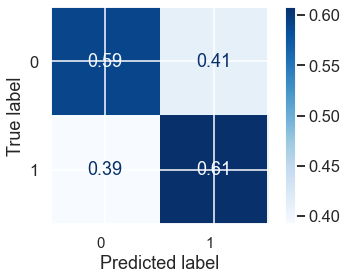

In [35]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(lr_pipeline_2, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

## K Nearest Neighbors

In [36]:
knn_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), KNN())



In [37]:
history.report(knn_pipeline,x_train, y_train, 'KNN - Defaults', 
               'KNN with All Features')

Average Accuracy Score: 0.5750758192073514
Average Recall Score: 0.4548410487457315
Average Precision Score: 0.3175573199178698
Average F1 Score: 0.37369948765880484


In [38]:
knn_pipeline.fit(x_train, y_train)
knn_pipeline.score(x_test, y_test)

0.5841779975278121

In [39]:
train_preds = knn_pipeline.predict(x_train)
test_preds = knn_pipeline.predict(x_test)

In [40]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.770681699328041
Recall Score: 0.7367727047964397
Accuracy Score: 0.7367727047964397
F1 Score: 0.7468277965066266


Precision Score: 0.6362636922962702
Recall Score: 0.5841779975278121
Accuracy Score: 0.5841779975278121
F1 Score: 0.6021976635392569




<Figure size 720x720 with 0 Axes>

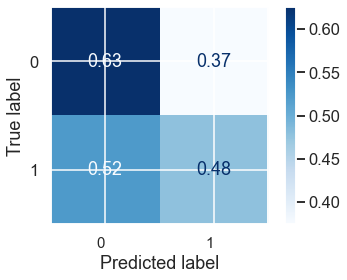

In [41]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(knn_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [42]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8940
False    3194
Name: final_result, dtype: int64


In [43]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2363
False    1682
Name: final_result, dtype: int64


## Decision Tree Model

In [44]:
dt_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(random_state = 2021))

In [45]:
history.report(dt_pipeline,x_train, y_train, 'Decision Tree - Defaults', 
               'Decision Tree with All Features')

Average Accuracy Score: 0.6417507480058835
Average Recall Score: 0.2561845908748733
Average Precision Score: 0.32247829033649245
Average F1 Score: 0.2851174166093356


In [46]:
dt_pipeline.fit(x_train, y_train)
dt_pipeline.score(x_test, y_test)

0.6563658838071693

In [47]:
train_preds = dt_pipeline.predict(x_train)
test_preds = dt_pipeline.predict(x_test)

In [48]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.8099567095984587
Recall Score: 0.8174550848854458
Accuracy Score: 0.8174550848854458
F1 Score: 0.8099738014213546


Precision Score: 0.6349008000437623
Recall Score: 0.6563658838071693
Accuracy Score: 0.6563658838071693
F1 Score: 0.6437495390437228




<Figure size 720x720 with 0 Axes>

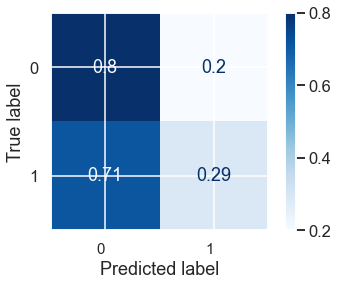

In [49]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(dt_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [50]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9919
False    2215
Name: final_result, dtype: int64


In [51]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2655
False    1390
Name: final_result, dtype: int64


### Max Depth of Tree

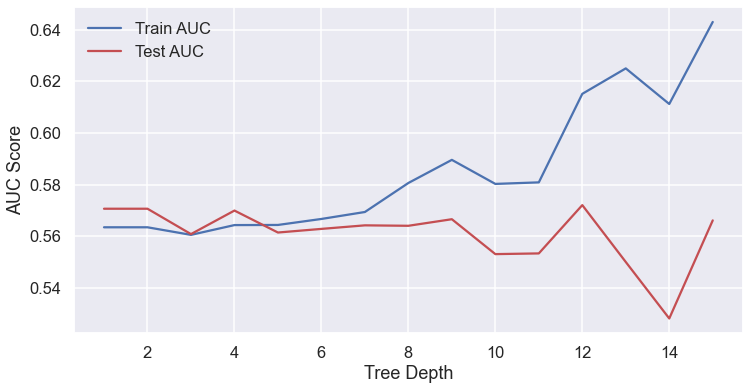

In [52]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    
    dt_depth_p = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT( max_depth=max_depth,
                                         random_state = 1))
    dt_depth_p.fit(x_train, y_train)
    train_pred = dt_depth_p.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt_depth_p.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()

In [53]:
# Max depth 5 or 7

In [54]:
dt_pipe_2 = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(random_state = 2021, max_depth = 7))

In [55]:
history.report(dt_pipe_2,x_train, y_train, 'Decision Tree - Depth 9', 
               'Decision Tree with Max Depth of 9')

Average Accuracy Score: 0.672988125618811
Average Recall Score: 0.2999864207719904
Average Precision Score: 0.39067591413019664
Average F1 Score: 0.338106984874076


In [56]:
dt_pipe_2.fit(x_train, y_train)
dt_pipe_2.score(x_test, y_test)

0.676885043263288

In [57]:
train_preds = dt_pipe_2.predict(x_train)
test_preds = dt_pipe_2.predict(x_test)

In [58]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.660304042116357
Recall Score: 0.680237349596176
Accuracy Score: 0.680237349596176
F1 Score: 0.6681233453583023


Precision Score: 0.6553767950756867
Recall Score: 0.676885043263288
Accuracy Score: 0.676885043263288
F1 Score: 0.6636934605743967




<Figure size 720x720 with 0 Axes>

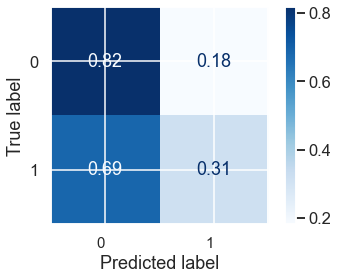

In [59]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(dt_pipe_2, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [60]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8254
False    3880
Name: final_result, dtype: int64


In [61]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2738
False    1307
Name: final_result, dtype: int64


### Improved

## Random Forest Model

In [62]:
rf_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), RFC(max_depth = 7, random_state = 2021))

In [63]:
history.report(rf_pipeline,x_train, y_train, 'Random Forest - Defaults', 
               'Random Forest with All Features')

Average Accuracy Score: 0.6658177269584987
Average Recall Score: 0.3362141081940023
Average Precision Score: 0.38665254927507947
Average F1 Score: 0.3594238048101416


In [64]:
rf_pipeline.fit(x_train, y_train)
rf_pipeline.score(x_test, y_test)

0.6716934487021013

In [65]:
train_preds = rf_pipeline.predict(x_train)
test_preds = rf_pipeline.predict(x_test)

In [66]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6636540451773155
Recall Score: 0.6785890885116203
Accuracy Score: 0.6785890885116203
F1 Score: 0.669937791515848


Precision Score: 0.6571748292044549
Recall Score: 0.6716934487021013
Accuracy Score: 0.6716934487021013
F1 Score: 0.6633819049688865




<Figure size 720x720 with 0 Axes>

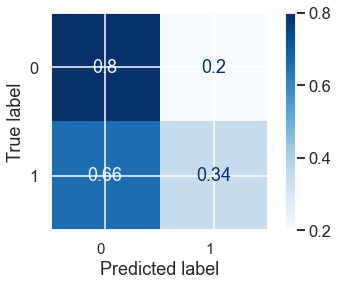

In [67]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(rf_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [68]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8234
False    3900
Name: final_result, dtype: int64


In [69]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2717
False    1328
Name: final_result, dtype: int64


### Improved

## Gradient Boost

In [70]:
gbc_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), GBC(max_depth = 7, random_state = 2021))

In [71]:
history.report(gbc_pipeline,x_train, y_train, 'Gradient Boost - Defaults', 
               'Gradient Boost with All Features')

Average Accuracy Score: 0.6939174185206664
Average Recall Score: 0.210028307282112
Average Precision Score: 0.4071135441237522
Average F1 Score: 0.27694428329473536


In [72]:
gbc_pipeline.fit(x_train, y_train)
gbc_pipeline.score(x_test, y_test)

0.6894932014833127

In [73]:
train_preds = gbc_pipeline.predict(x_train)
test_preds = gbc_pipeline.predict(x_test)

In [74]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.7233912656184115
Recall Score: 0.7471567496291412
Accuracy Score: 0.7471567496291412
F1 Score: 0.7214158859891652


Precision Score: 0.649166069683979
Recall Score: 0.6894932014833127
Accuracy Score: 0.6894932014833127
F1 Score: 0.6594137510242614




<Figure size 720x720 with 0 Axes>

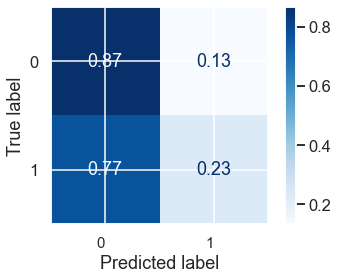

In [75]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(gbc_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [76]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9066
False    3068
Name: final_result, dtype: int64


In [77]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2789
False    1256
Name: final_result, dtype: int64


## XGBoost

In [78]:
xgb_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), XGB(use_label_encoder=False, verbosity=0))

In [79]:
history.report(xgb_pipeline,x_train, y_train, 'XGBoost - Defaults', 
               'XGBoost with All Features')

Average Accuracy Score: 0.6991102023520591
Average Recall Score: 0.21170817799138283
Average Precision Score: 0.42257197072629865
Average F1 Score: 0.2818197200809728


In [80]:
xgb_pipeline.fit(x_train, y_train)
xgb_pipeline.score(x_test, y_test)

0.6889987639060569

In [81]:
train_preds = xgb_pipeline.predict(x_train)
test_preds = xgb_pipeline.predict(x_test)

In [82]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.7163485365439971
Recall Score: 0.7421295533212461
Accuracy Score: 0.7421295533212461
F1 Score: 0.7147374112701975


Precision Score: 0.6468336201719881
Recall Score: 0.6889987639060569
Accuracy Score: 0.6889987639060569
F1 Score: 0.6572670241237389




<Figure size 720x720 with 0 Axes>

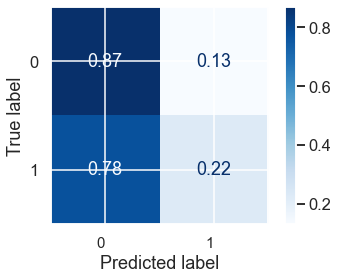

In [83]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(xgb_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [84]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9005
False    3129
Name: final_result, dtype: int64


In [85]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2787
False    1258
Name: final_result, dtype: int64


## Demographic Features Random Forest

In [86]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12134 entries, 1739 to 5312
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      12134 non-null  int64  
 1   code_module        12134 non-null  object 
 2   date_registration  12134 non-null  int64  
 3   sum_click          12134 non-null  int64  
 4   gender             12134 non-null  object 
 5   region             12134 non-null  object 
 6   highest_education  12134 non-null  object 
 7   imd_band           12134 non-null  object 
 8   age_band           12134 non-null  object 
 9   attempts           12134 non-null  int64  
 10  studied_credits    12134 non-null  int64  
 11  disability         12134 non-null  object 
 12  mean_score         12134 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 1.3+ MB


In [91]:
labels = ['gender', 'region', 'highest_education', 'imd_band', 
          'age_band', 'attempts', 'studied_credits', 'disability']

x_train_demo = x_train[labels]
x_test_demo = x_test[labels]


In [92]:
cat_cols = x_train_demo.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train_demo.columns.get_loc(col))

transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)])

In [99]:
dm_lr_pipe = make_pipeline(transformer, StandardScaler(with_mean = False),SMOTE(), 
                           RFC(max_depth = 7, random_state = 2021))

In [100]:
history.report(dm_lr_pipe,x_train_demo, y_train, 'random Forest Demographics', 
               'Random Forest with Demographic Features and Best C value')

Average Accuracy Score: 0.6465306516037816
Average Recall Score: 0.3958891627146186
Average Precision Score: 0.374216542729915
Average F1 Score: 0.3845743324061648


In [101]:
dm_lr_pipe.fit(x_train_demo, y_train)
dm_lr_pipe.score(x_test_demo, y_test)

0.6430160692212609

In [102]:
train_preds = dm_lr_pipe.predict(x_train_demo)
test_preds = dm_lr_pipe.predict(x_test_demo)

In [103]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6657995641998856
Recall Score: 0.658315477171584
Accuracy Score: 0.658315477171584
F1 Score: 0.6618137612932453


Precision Score: 0.6525868812938929
Recall Score: 0.6430160692212609
Accuracy Score: 0.6430160692212609
F1 Score: 0.647441800062983




<Figure size 720x720 with 0 Axes>

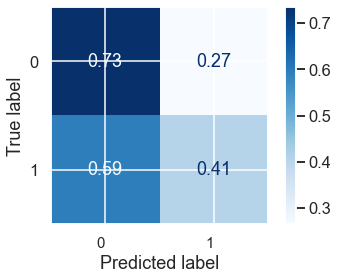

In [104]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(dm_lr_pipe, x_test_demo, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [105]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     7988
False    4146
Name: final_result, dtype: int64


In [106]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2601
False    1444
Name: final_result, dtype: int64


## Numeric Features 

In [118]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12134 entries, 1739 to 5312
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      12134 non-null  int64  
 1   code_module        12134 non-null  object 
 2   date_registration  12134 non-null  int64  
 3   sum_click          12134 non-null  int64  
 4   gender             12134 non-null  object 
 5   region             12134 non-null  object 
 6   highest_education  12134 non-null  object 
 7   imd_band           12134 non-null  object 
 8   age_band           12134 non-null  object 
 9   attempts           12134 non-null  int64  
 10  studied_credits    12134 non-null  int64  
 11  disability         12134 non-null  object 
 12  mean_score         12134 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 1.3+ MB


In [119]:
labels = ['course_length', 'date_registration', 
          'sum_click', 'mean_score']

In [120]:
x_train_num = x_train[labels]
x_test_num = x_test[labels]

In [121]:
num_rf_pipe = make_pipeline(StandardScaler(with_mean = False),SMOTE(), 
                           RFC(max_depth = 7, random_state = 2021))

In [122]:
history.report(num_rf_pipe,x_train_num, y_train, 'Random Forest Course Info', 
               'Random Forest with Course Info Features')

Average Accuracy Score: 0.724986248643539
Average Recall Score: 0.7029049493811244
Average Precision Score: 0.505378684641777
Average F1 Score: 0.5877991753522848


In [123]:
num_rf_pipe.fit(x_train_num, y_train)
num_rf_pipe.score(x_test_num, y_test)

0.7147095179233621

In [124]:
train_preds = num_rf_pipe.predict(x_train_num)
test_preds = num_rf_pipe.predict(x_test_num)

In [125]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.7814924629876739
Recall Score: 0.7455084885445855
Accuracy Score: 0.7455084885445855
F1 Score: 0.7556047164076063


Precision Score: 0.7516241987134727
Recall Score: 0.7147095179233621
Accuracy Score: 0.7147095179233621
F1 Score: 0.7258622434172661




<Figure size 720x720 with 0 Axes>

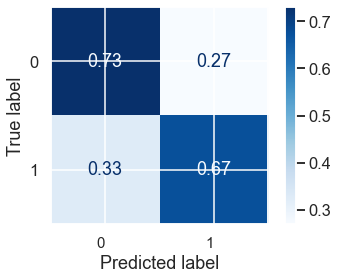

In [126]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(num_rf_pipe, x_test_num, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [127]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9046
False    3088
Name: final_result, dtype: int64


In [128]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2891
False    1154
Name: final_result, dtype: int64


## Numeric and Some Demographic Features

In [151]:
labels = ['gender', 'highest_education', 
          'imd_band', 'age_band', 'course_length', 
          'date_registration', 'sum_click', 'mean_score']

In [152]:
x_train_both = x_train[labels]
x_test_both = x_test[labels]

In [153]:
cat_cols = x_train_both.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train_both.columns.get_loc(col))

transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)])

In [154]:
dt_both_pipe = make_pipeline(transformer, StandardScaler(with_mean = False),SMOTE(), 
                           RFC(max_depth = 7, random_state = 2021))

In [155]:
history.report(dt_both_pipe,x_train_both, y_train, 'Random Forest Some Demographics ans Numeric', 
               'Random Forest with Some Demographic and Numeric Features')

Average Accuracy Score: 0.600543059741325
Average Recall Score: 0.5203336079080713
Average Precision Score: 0.3538280694286123
Average F1 Score: 0.4209338517746112


In [156]:
dt_both_pipe.fit(x_train_both, y_train)
dt_both_pipe.score(x_test_both, y_test)

0.5975278121137206

In [157]:
train_preds = dt_both_pipe.predict(x_train_both)
test_preds = dt_both_pipe.predict(x_test_both)

In [158]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.664498852130567
Recall Score: 0.6086204054722268
Accuracy Score: 0.6086204054722268
F1 Score: 0.6264646923500313


Precision Score: 0.6592443388309691
Recall Score: 0.5975278121137206
Accuracy Score: 0.5975278121137206
F1 Score: 0.6164675056736876




<Figure size 720x720 with 0 Axes>

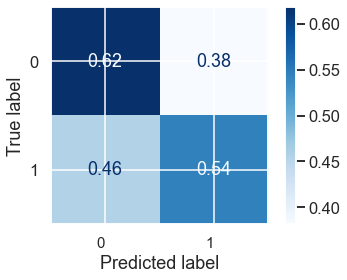

In [159]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(dt_both_pipe, x_test_both, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [160]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     7385
False    4749
Name: final_result, dtype: int64


In [161]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2417
False    1628
Name: final_result, dtype: int64


## Feature Importance Logistic Regression

In [170]:
upsample_pipe[3].coef_

array([[-0.14189635,  0.04122753,  0.04697608,  0.10352886, -0.15010857,
         0.05398902, -0.09160869, -0.05844461,  0.05853056, -0.01319014,
        -0.01942598, -0.02231874,  0.03482532, -0.0083644 ,  0.04858694,
         0.06889771, -0.0837641 , -0.04719391, -0.04961   ,  0.06735758,
        -0.00940115,  0.01301725, -0.08198516, -0.14260542,  0.18311371,
         0.05242596, -0.00765904,  0.11650298,  0.08935422,  0.03277101,
         0.02790907,  0.01135395,  0.01219953, -0.07110584, -0.02050684,
        -0.10240225, -0.10165958,  0.07538845, -0.07732077,  0.00746502,
        -0.03140195,  0.03155648]])

In [ ]:
names = x_train.columns
feature_importance = pd.DataFrame(names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()